#### 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats import t
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib
import glob
import os

from scipy.stats import trim_mean
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline
from matplotlib import cm 
import gc  # garbage collection
from sklearn.cluster import KMeans  # k-means 군집분석
from sklearn.metrics import silhouette_score  # 군집분석 평가를 위한 silhouette 값 계산

pd.set_option('max_columns', 20, 'max_rows', 20)

%matplotlib inline

# 한글 폰트 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
# 미세먼지 데이터 추출
dust_10 = pd.read_csv('미세먼지.csv')
dust_10.rename(columns = {'연도' : 'DYEAR', '월' : 'DMONTH', '일' :'DDATE'}, inplace = True)
dust_10 = dust_10.query('DYEAR == 2019')

# 패널 데이터 가져오기 
panel_raw = pd.read_excel('Panel Infomation_KM.xlsx' , header = 1)
panel_raw = panel_raw[['KMID','SEX','BIRTH','REGION 1', 'REGION 2', 'MARRIAGE', 'JOB', 'HOUSE INCOME (MONTHLY)']]
panel_raw.rename(columns = {'REGION 1' : 'REGION_01', 'REGION 2' : 'REGION_02'}, inplace = True)

# 패널 데이터 中 일련번호, 성별, 나이대, 지역명만 추출 
from datetime import datetime
 
standard_year = datetime.today().year  

def age_caculation(birth_year):
    if np.isnan(birth_year):
        age = birth_year
    else:
        age = 0 
        birth_year = int(birth_year) 

        if birth_year >= 2000:
            age = int((standard_year - birth_year) + 1)
        elif birth_year < 2000:
            age = int((2000 - birth_year) + 22)
    return age 

panel_raw['Age']  = panel_raw.loc[:, 'BIRTH'].agg(lambda x: age_caculation(x))
panel_raw['Age_range'] = panel_raw['Age'].map(lambda x: x if np.isnan(x) == True else str(int((x // 10) * 10)) + "대") 


panel = panel_raw[['KMID','SEX','Age','Age_range','REGION_01']]

##앱로그 데이터 불러오기 
input_file = r'C:\Users\gby1349\python\논문작성\applog'
file = glob.glob(os.path.join(input_file, 'applog_2019*.csv'))

data_raw = []


for i, file_name in enumerate(file):
    if i == 1:
        data_csv = pd.read_csv(file_name)
        data_csv = data_csv[data_csv['DMONTH'] == 2]
        data_raw.append(data_csv)
    elif i == 3:
        data_csv = pd.read_csv(file_name)
        data_csv = data_csv[(data_csv['DDATE'] <= 25) | (data_csv['DDATE'] >= 29)]
        data_raw.append(data_csv)
    else: 
        data_csv = pd.read_csv(file_name)
        data_raw.append(data_csv)   

data = pd.concat(data_raw)
del data['Unnamed: 0']

# com.android.settings 삭제 
data = data[data['app'] !='com.android.settings']

In [3]:
# 앱 데이터 추출(수도권)
appdata = pd.merge(data, panel , on = 'KMID', how = 'inner')
appdata = appdata.query('REGION_01 == "서울" or REGION_01 == "인천" or REGION_01 == "경기"')

# 미세먼지 데이터 추출(수도권)
dust_10['수도권 평균'] = dust_10.loc[:,['서울','경기','인천']].mean(axis = 1)
dust_original = dust_10.copy()

dust_10 = dust_10.query('DMONTH != 2 or DDATE != 1') # 2월 1일 누락된 거 맞춰주기 위함

dust_10_part1 = dust_10.iloc[:114,:]
dust_10_part2 =  dust_10.iloc[117:,:] 
dust_10= pd.concat([dust_10_part1 ,dust_10_part2 ]) # 4월 26일 ~ 28일 제거 

dust_10 = dust_10.query('DMONTH != 5 or DDATE != 31') # 5월 31일 누락된 거 맞춰주기 위함
dust_10 = dust_10.query('DMONTH != 7 or DDATE != 14') # 7월 14일 누락된거 맞춰주기 아픔
dust_10 = dust_10.query('DMONTH != 7 or DDATE != 31') # 7월 31일 누락된거 맞춰주기 아픔

dust_10 = dust_10.loc[:,['DYEAR','DMONTH','DDATE','수도권 평균']].round()

# 일별 미세먼지 변화량(수도권) 
dust_10_change = dust_10.diff().fillna(0)
dust_10_change['DYEAR'] = dust_10['DYEAR']
dust_10_change['DMONTH'] = dust_10['DMONTH']
dust_10_change['DDATE'] = dust_10['DDATE']

dust_10 = dust_10.pivot_table(index = ['DMONTH','DDATE'], values = '수도권 평균',
                                        aggfunc = 'sum', fill_value = 0).iloc[:,:]

dust_10_change = dust_10_change.pivot_table(index = ['DMONTH','DDATE'], 
                                            values = '수도권 평균', aggfunc = 'sum', fill_value = 0).iloc[:,:]

## Data의 정보

#### (1) 인구학적 정보 

- 수도권 데이터 정보
- 특이한점 
1. 수입 中 0으로 표시된 값(미기입): 191건
2. 직업 中 0으로 표시된 값(미기입): 495건
3. 결혼 여부 中 0으로 표시된 값(미기입): 189건

In [4]:
appdata_kmid = list(appdata['KMID'].unique())
panel_data = panel_raw.query('KMID in @appdata_kmid')

In [5]:

panel_data['JOB'] = panel_data['JOB'].agg(lambda x: "오기입" if x == 0 else x)
panel_data['MARRIAGE'] = panel_data['MARRIAGE'].agg(lambda x: "오기입" if x == 0 else x)
panel_data['HOUSE INCOME (MONTHLY)'] = panel_data['HOUSE INCOME (MONTHLY)'].agg(lambda x: "오기입" if x == 0 else x)

<ipython-input-5-233621c9e0ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_data['JOB'] = panel_data['JOB'].agg(lambda x: "오기입" if x == 0 else x)
<ipython-input-5-233621c9e0ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_data['MARRIAGE'] = panel_data['MARRIAGE'].agg(lambda x: "오기입" if x == 0 else x)
<ipython-input-5-233621c9e0ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

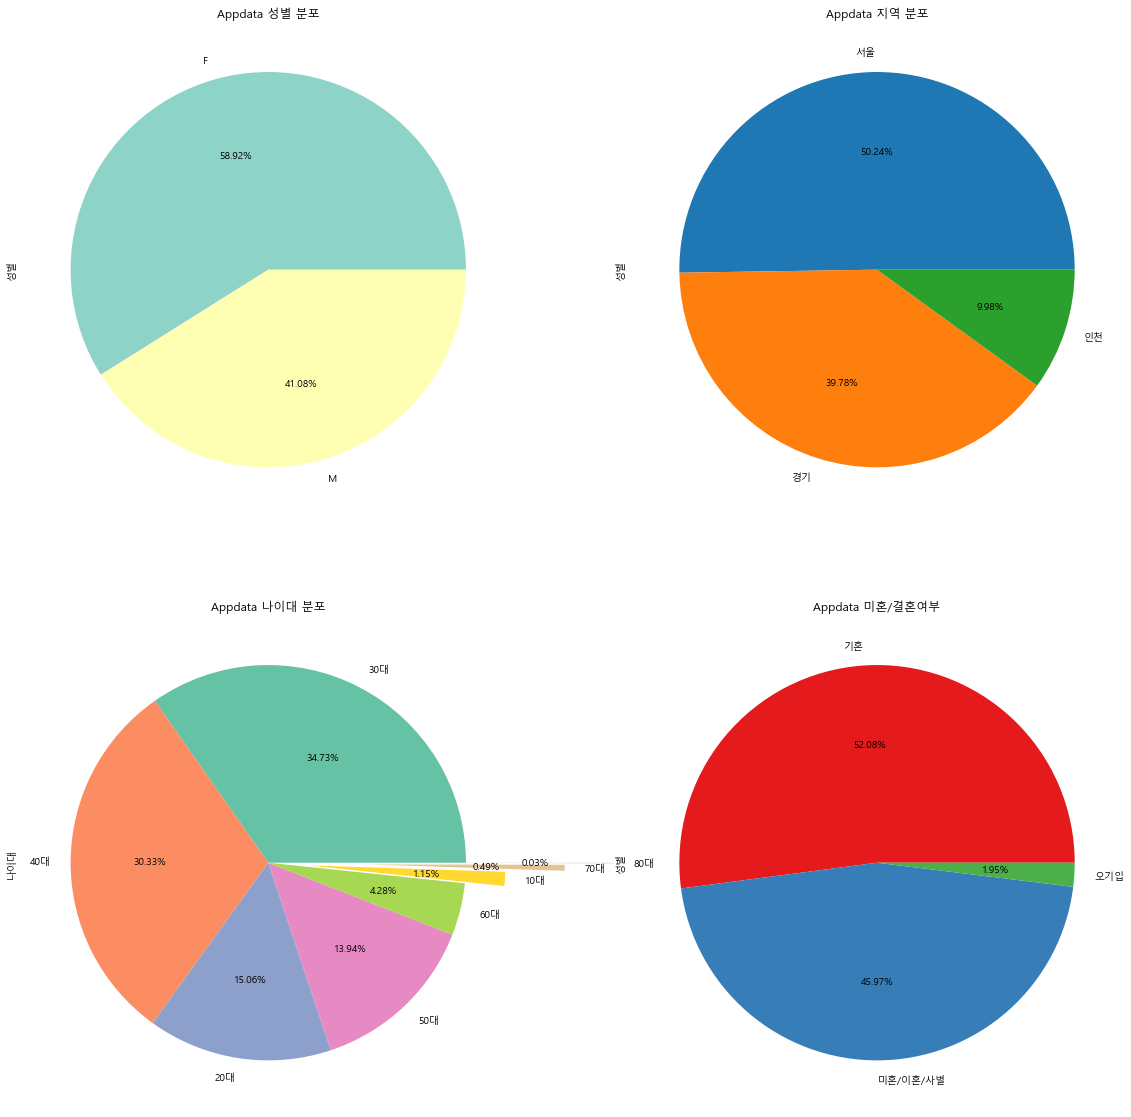

In [6]:
# 주요 인구학적 정보
from matplotlib import cm 
color_sex = cm.get_cmap('Set3')(np.arange(2))
color_age = cm.get_cmap('Set2')(np.arange(8))
color_marry = cm.get_cmap('Set1')(np.arange(3))
explode = [0,0,0,0,0,0.2, 0.5, 0.75]

fig, ax = plt.subplots(2,2,figsize = (20,20))
panel_data['SEX'].value_counts().plot.pie(ax = ax[0,0], title = "Appdata 성별 분포", ylabel = "성별", 
                                          autopct = "%.2f%%", colors = color_sex)

panel_data['REGION_01'].value_counts().plot.pie(ax = ax[0, 1], title = "Appdata 지역 분포", ylabel = "성별", 
                                          autopct = "%.2f%%")


panel_data['Age_range'].value_counts().plot.pie(ax = ax[1, 0], title = "Appdata 나이대 분포", ylabel = "나이대", 
                                                autopct = '%.2f%%', colors = color_age, explode = explode)

panel_data['MARRIAGE'].value_counts().plot.pie(ax = ax[1,1], title = "Appdata 미혼/결혼여부", ylabel = "성별", 
                                               autopct = "%.2f%%", colors = color_marry)

plt.show()

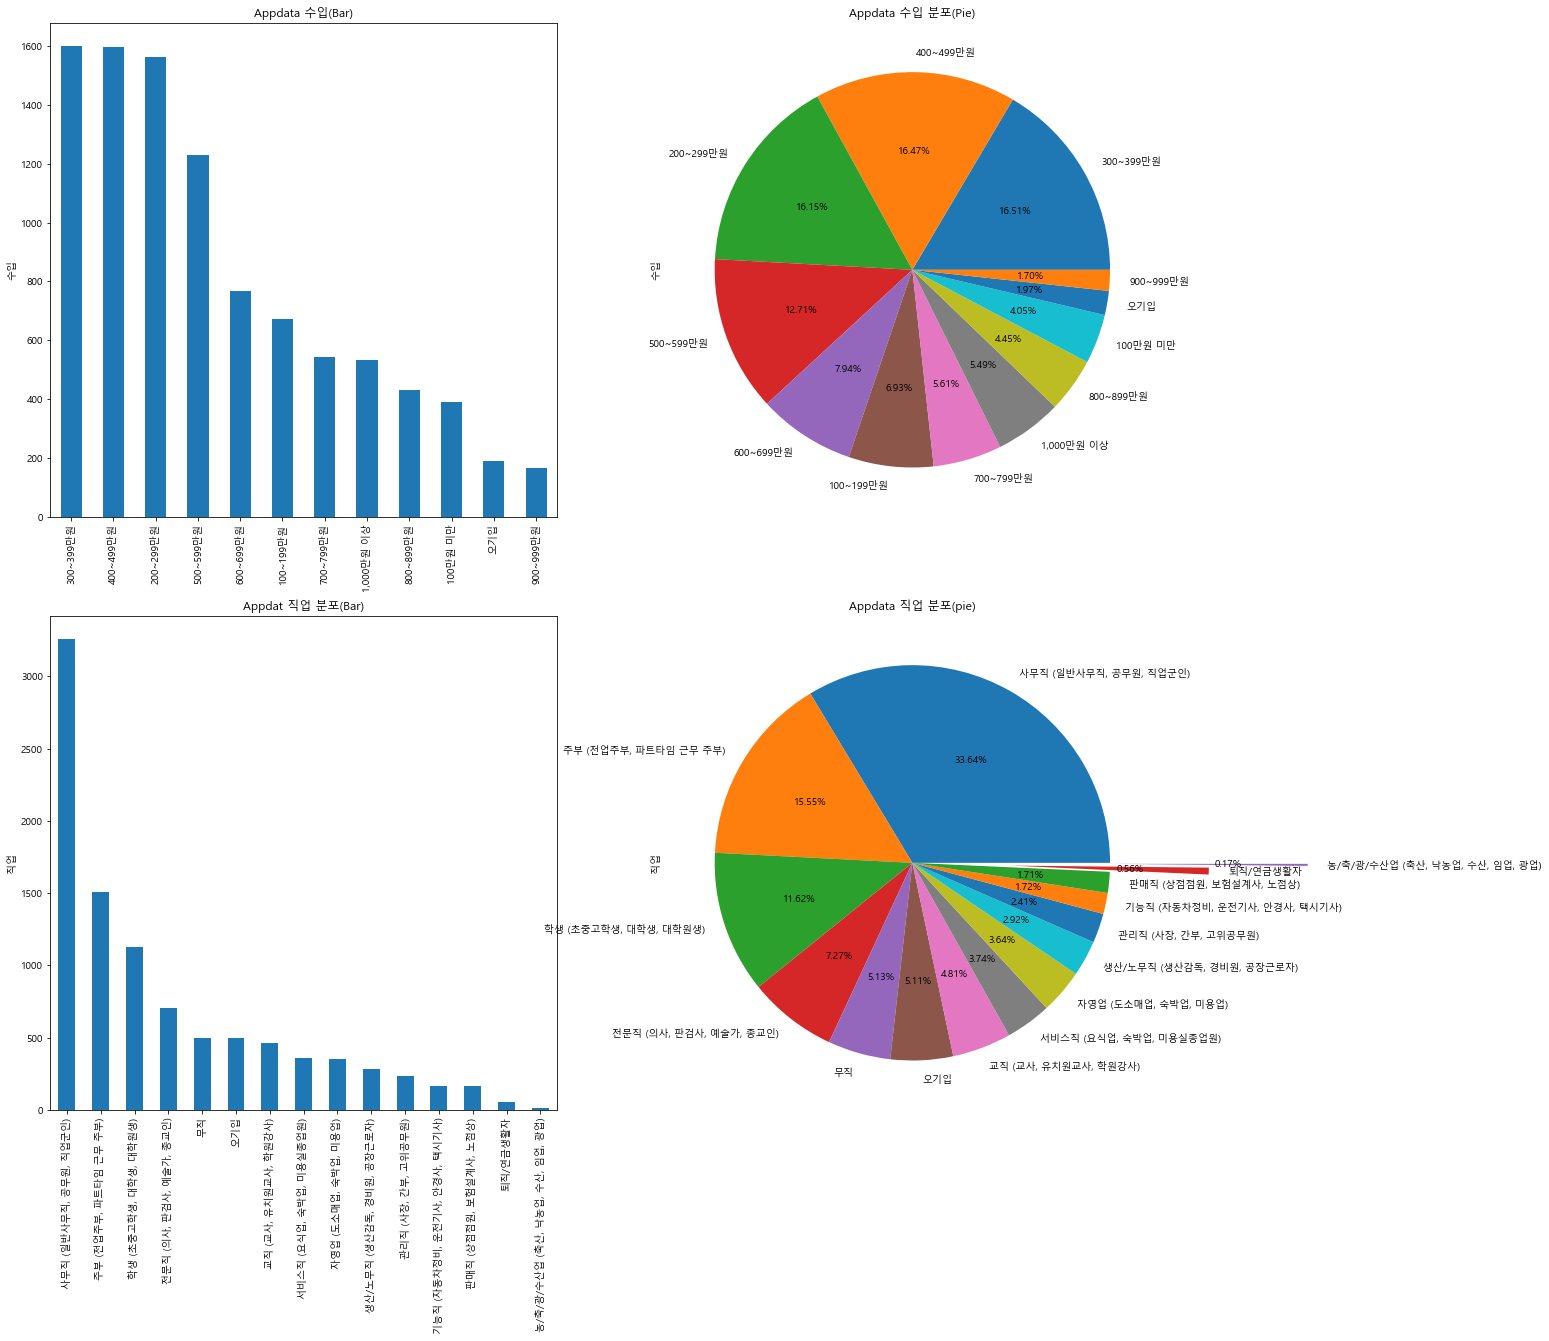

In [7]:
fig, ax = plt.subplots(2,2,figsize = (20,20))
panel_data['HOUSE INCOME (MONTHLY)'].value_counts().plot.bar(ax = ax[0, 0], title = "Appdata 수입(Bar)", ylabel = "수입")
 
panel_data['HOUSE INCOME (MONTHLY)'].value_counts().plot.pie(ax = ax[0, 1], title = "Appdata 수입 분포(Pie)", ylabel = "수입", 
                                          autopct = "%.2f%%")

explode = [0,0,0,0,0,0,0,0,0,0,0,0,0,0.5, 1.0]
panel_data['JOB'].value_counts().plot.bar(ax = ax[1, 0], title = "Appdat 직업 분포(Bar)", ylabel = "직업")

panel_data['JOB'].value_counts().plot.pie(ax = ax[1, 1], title = "Appdata 직업 분포(pie)", ylabel = "직업", autopct = "%.2f%%"
                                         ,explode = explode)

plt.show()

In [8]:
#### 각 지역(서울  / 경기도 / 인천별로 세부 분포도 확인)

In [9]:
age_range = sorted(list(panel_data.Age_range.unique()))

print("---------- 인구학적 정보 ----------")
print("총 대상 인원: {}명 \n".format(panel_data.shape[0]))
print("1. 성별 정보")
print("여성: {}명 / 남성: {}명 \n".format(panel_data['SEX'].value_counts()[0], panel_data['SEX'].value_counts()[1]))

print("2. 연령대 정보")
value  = panel_data['Age_range'].value_counts().reindex(age_range)
for i in range(8):
    print("나이 연령({}): {}명".format(age_range[i], value[i]))

print("\n3. 지역 정보")
for i in range(3):
    print("지역({}): {}명".format(panel_data['REGION_01'].value_counts().index[i], panel_data['REGION_01'].value_counts()[i]))
    
print("\n4. 결혼 정보")
for i in range(3):
    print("결혼여부 ({}): {}명".format(panel_data['MARRIAGE'].value_counts().index[i], panel_data['MARRIAGE'].value_counts()[i]))
    
print("\n5. 직업 정보")
for i in range(len(panel_data['JOB'].value_counts())):
    print("직장정보 [{}]: {}명".format(panel_data['JOB'].value_counts().index[i], panel_data['JOB'].value_counts()[i]))
    
print("\n6.Income 정보")
for i in range(len(panel_data['HOUSE INCOME (MONTHLY)'].value_counts())):
    print("Income 정보 [{}]: {}명".format(panel_data['HOUSE INCOME (MONTHLY)'].value_counts().index[i],
                                       panel_data['HOUSE INCOME (MONTHLY)'].value_counts()[i]))
    
print('\n 전처리후  app 데이터 일자 정보')
print("app 데이터의 날짜 수: {}일".format(appdata.drop_duplicates(['DMONTH','DDATE']).shape[0]))

---------- 인구학적 정보 ----------
총 대상 인원: 9683명 

1. 성별 정보
여성: 5705명 / 남성: 3978명 

2. 연령대 정보
나이 연령(10대): 111명
나이 연령(20대): 1458명
나이 연령(30대): 3363명
나이 연령(40대): 2937명
나이 연령(50대): 1350명
나이 연령(60대): 414명
나이 연령(70대): 47명
나이 연령(80대): 3명

3. 지역 정보
지역(서울): 4865명
지역(경기): 3852명
지역(인천): 966명

4. 결혼 정보
결혼여부 (기혼): 5043명
결혼여부 (미혼/이혼/사별): 4451명
결혼여부 (오기입): 189명

5. 직업 정보
직장정보 [사무직 (일반사무직, 공무원, 직업군인)]: 3257명
직장정보 [주부 (전업주부, 파트타임 근무 주부)]: 1506명
직장정보 [학생 (초중고학생, 대학생, 대학원생)]: 1125명
직장정보 [전문직 (의사, 판검사, 예술가, 종교인)]: 704명
직장정보 [무직]: 497명
직장정보 [오기입]: 495명
직장정보 [교직 (교사, 유치원교사, 학원강사)]: 466명
직장정보 [서비스직 (요식업, 숙박업, 미용실종업원)]: 362명
직장정보 [자영업 (도소매업, 숙박업, 미용업)]: 352명
직장정보 [생산/노무직 (생산감독, 경비원, 공장근로자)]: 283명
직장정보 [관리직 (사장, 간부, 고위공무원)]: 233명
직장정보 [기능직 (자동차정비, 운전기사, 안경사, 택시기사)]: 167명
직장정보 [판매직 (상점점원, 보험설계사, 노점상)]: 166명
직장정보 [퇴직/연금생활자]: 54명
직장정보 [농/축/광/수산업 (축산, 낙농업, 수산, 임업, 광업)]: 16명

6.Income 정보
Income 정보 [300~399만원]: 1599명
Income 정보 [400~499만원]: 1595명
Income 정보 [200~299만원]: 1564명
Income 정보 [500~599만원]: 1231명
Income 정보 [600~69

#### 날씨 정보 

In [10]:
# 2019냔 기상 데이터 가져오기
weather_inf = pd.read_csv('2019년 기상데이터.csv', encoding='cp949')
weather_inf['일시'] = pd.to_datetime(weather_inf['일시'])
weather_inf = weather_inf.query('지점명 != "백령도"')

# 일별 합치기 
weather_2019 = weather_inf.set_index('일시')
weather_2019 = weather_2019.resample('D').mean().round(2)
del weather_2019['지점']

# 강수 계속시간 
weather_rain = weather_inf.query('지점명 == "서울" or 지점명 == "인천" or 지점명 == "수원"').fillna(0)
weather_rain = pd.DataFrame(weather_rain.groupby('일시')['강수 계속시간(hr)'].mean().round(2))
weather_2019['강수 계속시간(hr)'] = weather_rain['강수 계속시간(hr)']

# 미세먼지 데이터와 행 수 맞추기 
part_01 = weather_2019.iloc[:31]
part_02 = weather_2019.iloc[32:115]
part_03 = weather_2019.iloc[118:150]
part_04 = weather_2019.iloc[151:194]
part_05 = weather_2019.iloc[195:211]
part_06 = weather_2019.iloc[212:]
weather = pd.concat([part_01, part_02, part_03, part_04, part_05, part_06]);weather.head()

# 미세먼지 데이터 맞추기 
weather = pd.concat([weather.reset_index(), dust_10.reset_index()], axis = 1)
weather = weather.set_index('일시')
del weather['DMONTH'], weather['DDATE']
weather = weather.rename(columns = {'수도권 평균' :'미세먼지'})
display(weather)

,평균기온(°C),최저기온(°C),최고기온(°C),강수 계속시간(hr),일강수량(mm),최대 순간 풍속(m/s),최대 풍속(m/s),평균 풍속(m/s),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),가조시간(hr),합계 일사량(MJ/m2),일 최심신적설(cm),일 최심적설(cm),평균 전운량(1/10),평균 지면온도(°C),미세먼지
일시,,,,,,,,,,,,,,,,,,,
2019-01-01,-5.91,-11.30,-0.04,0.00,NaN,8.34,5.03,1.83,57.65,2.25,1025.73,1036.26,9.62,7.51,NaN,NaN,2.91,-4.64,38
2019-01-02,-5.92,-11.62,0.85,0.00,NaN,5.44,3.56,1.23,51.95,1.93,1026.58,1037.07,9.64,10.32,NaN,NaN,0.18,-5.14,37
2019-01-03,-4.88,-11.61,3.11,0.00,NaN,4.27,2.78,0.99,49.86,1.98,1027.41,1037.70,9.66,10.22,NaN,NaN,0.65,-4.57,41
2019-01-04,-2.75,-9.52,3.75,0.08,0.00,5.06,3.32,1.03,64.95,3.31,1022.66,1035.81,9.66,5.73,NaN,NaN,4.18,-3.24,60
2019-01-05,-3.32,-7.51,1.94,0.00,NaN,7.09,4.22,1.86,44.15,2.05,1019.62,1029.75,9.68,9.95,NaN,NaN,1.41,-3.32,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,-2.04,-5.84,2.84,0.00,NaN,6.90,4.06,1.60,60.34,3.06,1017.25,1028.45,9.60,10.22,NaN,NaN,0.05,-0.85,35
2019-12-28,0.41,-5.26,5.62,0.00,NaN,5.22,3.31,1.44,63.31,3.92,1020.86,1030.10,9.60,8.01,NaN,NaN,3.26,-0.62,45
2019-12-29,2.80,-0.85,6.39,7.72,0.71,4.89,3.12,1.46,68.85,5.07,1018.15,1029.68,9.60,3.34,NaN,NaN,9.01,1.15,47


In [11]:
#### 파생변수 제작 (1) 불쾌 지수 산출
discomfort_degree = []

for i in range(weather.shape[0]):
    tmp = weather['평균기온(°C)'][i]
    hum = weather['평균 상대습도(%)'][i] / 100
    discomfort_value = np.round(((9 / 5) * tmp) - (0.55 * (1 - hum) * (9 / 5 * tmp - 26)) + 32 , 2)
    discomfort_degree.append(discomfort_value)
    
    
#### 파생변수 제작 (2) 열 지수 산출
temperature_degree = []

for i in range(weather.shape[0]):
    tmp_f = np.round((weather['평균기온(°C)'][i] * 9 / 5) + 32,2)
    hum = weather['평균 상대습도(%)'][i] / 100
    tem_value = (-42.38 + 2.05 * tmp_f + 10.13 * hum - 0.22 * tmp_f * hum - 6.84 * 10 ** (-3) * tmp_f ** 2 - 
                 5.48 * 10 ** (-2) * hum ** 2 + 1.29 * 10 ** (-3) * tmp_f ** 2 * hum + 8.53 * 10 ** (-4) * tmp_f * hum **2 -
                1.99 * 10 ** (-6) * tmp_f ** 2  * hum ** 2)
    temperature_degree.append(tem_value)

    
#### 파생변수 제작 (3) 체감온도 산출
real_tem_degree = []

for i in range(weather.shape[0]):
    tmp = weather['평균기온(°C)'][i]
    wind = weather['평균 풍속(m/s)'][i] 
    real_tem_value = 13.12 + 0.6215 * tmp - 11.37 * wind ** 0.16 + 0.3965 * tmp * wind ** 0.16
    real_tem_degree.append(real_tem_value)
    
weather['체감온도'] = real_tem_degree
weather['열지수'] = temperature_degree
weather['불쾌지수'] = discomfort_degree 

# 강수 여부 만들기
weather['일강수량(mm)'] = weather['일강수량(mm)'].fillna(0)

# 미세 먼지 
fill_value = round(49.893758,0) - weather['미세먼지'][0]
weather['미세먼지_변화량'] =  weather['미세먼지'].diff().fillna(fill_value)

In [12]:
display(weather.loc['2019-02-02','미세먼지_변화량'])
display(weather.loc['2019-04-29','미세먼지_변화량'])
display(weather.loc['2019-06-01','미세먼지_변화량'])
display(weather.loc['2019-07-15','미세먼지_변화량'])
display(weather.loc['2019-08-01','미세먼지_변화량'])

weather.loc['2019-02-02','미세먼지_변화량'] = 20
weather.loc['2019-04-29','미세먼지_변화량'] = 9
weather.loc['2019-06-01','미세먼지_변화량'] = 11
weather.loc['2019-07-15','미세먼지_변화량'] = 4
weather.loc['2019-08-01','미세먼지_변화량'] = -4

-10.0

-13.0

-15.0

17.0

-5.0

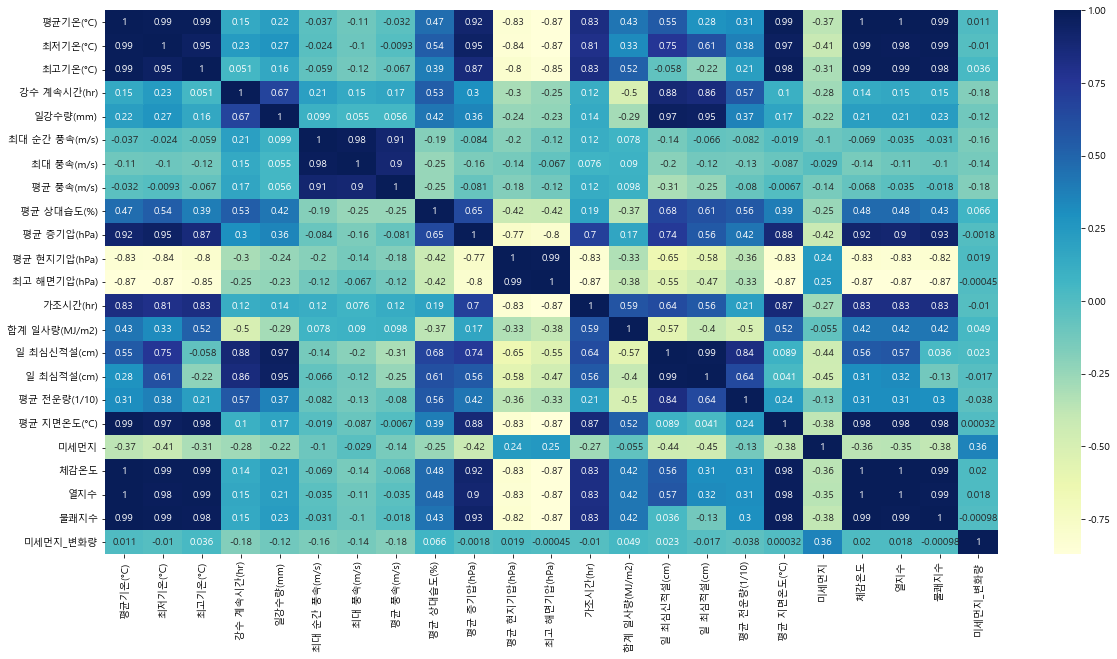

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(weather.iloc[:,:].corr(), annot=True, cmap="YlGnBu")
plt.show()

In [14]:
# 날씨 데이터 정리
weather = weather[['평균기온(°C)','평균 풍속(m/s)','강수 계속시간(hr)','일강수량(mm)','평균 상대습도(%)',
                   '합계 일사량(MJ/m2)','평균 전운량(1/10)','미세먼지','미세먼지_변화량']]

weather = weather.rename(columns = {'평균기온(°C)' : '평균기온', '평균 풍속(m/s)' : '평균풍속', 
                                    '평균 상대습도(%)' : '평균상대습도', '평균 전운량(1/10)' : '평균전운량',
                                   '합계 일사량(MJ/m2)' : '합계일사량', '강수 계속시간(hr)': '강수지속시간',
                                   '일강수량(mm)' : '일강수량'})

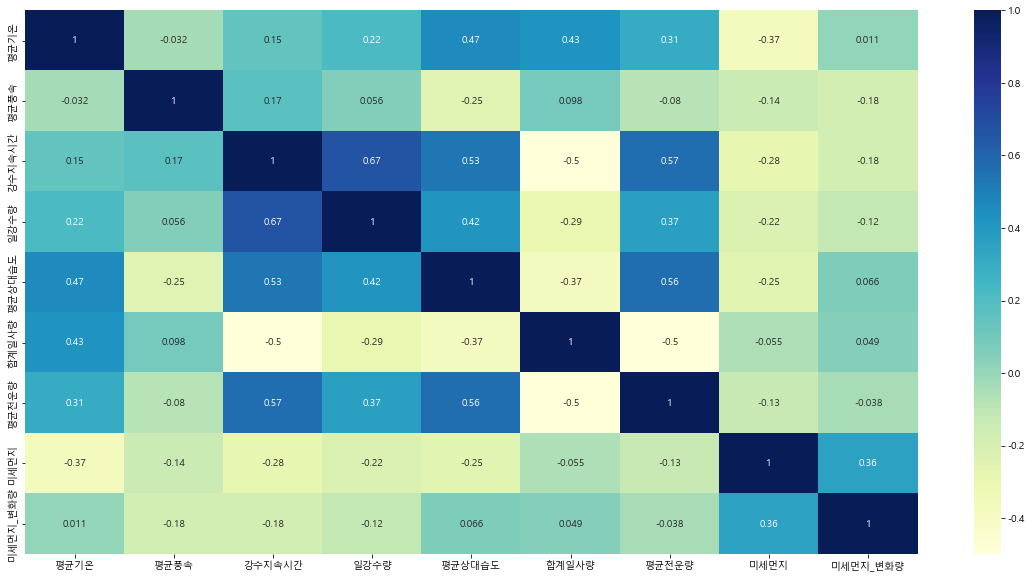

In [15]:
plt.figure(figsize=(20,10))
sns.heatmap(weather.iloc[:,:].corr(), annot=True, cmap="YlGnBu")
plt.show()

In [16]:
weather[weather['평균풍속'] == weather['평균풍속'].max()]

,평균기온,평균풍속,강수지속시간,일강수량,평균상대습도,합계일사량,평균전운량,미세먼지,미세먼지_변화량
일시,,,,,,,,,
2019-09-07,25.54,5.9,13.64,3.94,79.62,3.78,8.9,18,-1.0


In [17]:
weather = weather[weather['평균풍속'] != weather['평균풍속'].max()]

# 일 강수량 특이값 제외 
weather['강수지속시간'] = weather['강수지속시간'].agg(lambda x: "0(맑음)" if x== 0 else "1시간 미만" if x<1 else "1~5시간" if x<5 else "5시간 초과")
weather['일강수량'] = weather['일강수량'].agg(lambda x: "0mm" if x == 0 else "10mm 미만" if x <10 else "10mm 이상")

#### 데이터 정제

In [18]:
data = appdata.groupby(['DYEAR','DMONTH','DDATE','category'])['USE_TIME'].sum().reset_index()
data = data.query('DMONTH != 9 or DDATE != 7')

data['DYEAR'] = data['DYEAR'].agg(lambda x: str(x))
data['DMONTH'] = data['DMONTH'].agg(lambda x: '0' + str(x) if x <=9 else str(x))
data['DDATE'] = data['DDATE'].agg(lambda x: '0' + str(x) if x <=9 else str(x))

data['일시'] = data['DYEAR'] + data['DMONTH'] + data['DDATE']
data = data[['일시','category','USE_TIME']]

data['일시'] = pd.to_datetime(data['일시'])
data.head()

,일시,category,USE_TIME
0,2019-01-01,Art&design,601914
1,2019-01-01,Auto&vehicles,33910398
2,2019-01-01,Beauty,22857947
3,2019-01-01,Books&Reference,6073498792
4,2019-01-01,Business,227420017


#### 데이터 합치기

In [19]:
value = pd.merge(data, weather.reset_index(), how = 'left', on = '일시')
value = value.set_index('일시')

value_y = value['USE_TIME']
del value['USE_TIME']

In [20]:
cat_features = value.select_dtypes(include=['object']).columns.to_list()
num_features = value.select_dtypes(exclude='object').columns.to_list()

cat_features = value.select_dtypes(include=['object']).columns.to_list()
num_features = value.select_dtypes(exclude='object').columns.to_list()

value = pd.concat([value[cat_features], value[num_features].apply(lambda x: ((x - x.mean()) /  x.std()), axis=0)], axis = 1)
value = value.reset_index('일시')

In [21]:
# 공휴일 
import requests
from urllib import parse
import datetime
from datetime import datetime
from bs4 import BeautifulSoup

url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoServices/getRestDeInfo?'
api_key = 'Q1XQDny72%2FC2oUmsbNxIdKHRVqAmXzAufPojvt9aP4cqDORt9lvmFqSDnTjra7gzWVB8cbqW7KRw4rFvqDXyFA%3D%3D'
year = '2019'
    
find_url = url + 'serviceKey=' + api_key + '&' + 'solYear=' + year
response = requests.get('http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?serviceKey=Q1XQDny72%2FC2oUmsbNxIdKHRVqAmXzAufPojvt9aP4cqDORt9lvmFqSDnTjra7gzWVB8cbqW7KRw4rFvqDXyFA%3D%3D&solYear=2019')
xml = BeautifulSoup(response.text, "lxml")
items = xml.find('items')
item_list = []
for item in items:
    item_dict = {
        "이름" : item.find("datename").text.strip(),
        "날짜" : datetime.strptime(item.find("locdate").text.strip(), "%Y%m%d")
    }
    item_list.append(item_dict)

holiday_inf = pd.DataFrame(item_list)

holiday_1 = list(holiday_inf['날짜'])

# 주중/주말여부
value['주말여부'] = value['일시'].dt.dayofweek
value['주말여부'] = value['주말여부'].agg(lambda x : '주중' if x <=4 else "주말")

holiday_2 = list(value.query('주말여부 == "주말"')['일시'])

del value['주말여부']

value['휴일여부'] = value['일시'].agg(lambda x: "휴일" if x in list((holiday_1 + holiday_2)) else "휴일 아님")

# 월 정보
value['월'] = value['일시'].dt.month
value['월'] = value['월'].agg(lambda x: str(int(x)) + '월')

In [22]:
value['USE_TIME'] = list(value_y) # 종속변수 추가
value.head()

,일시,category,강수지속시간,일강수량,평균기온,평균풍속,평균상대습도,합계일사량,평균전운량,미세먼지,미세먼지_변화량,휴일여부,월,USE_TIME
0,2019-01-01,Art&design,0(맑음),0mm,-1.833547,0.150976,-0.600268,-0.96811,-0.744023,-0.258076,0.658731,휴일,1월,601914
1,2019-01-01,Auto&vehicles,0(맑음),0mm,-1.833547,0.150976,-0.600268,-0.96811,-0.744023,-0.258076,0.658731,휴일,1월,33910398
2,2019-01-01,Beauty,0(맑음),0mm,-1.833547,0.150976,-0.600268,-0.96811,-0.744023,-0.258076,0.658731,휴일,1월,22857947
3,2019-01-01,Books&Reference,0(맑음),0mm,-1.833547,0.150976,-0.600268,-0.96811,-0.744023,-0.258076,0.658731,휴일,1월,6073498792
4,2019-01-01,Business,0(맑음),0mm,-1.833547,0.150976,-0.600268,-0.96811,-0.744023,-0.258076,0.658731,휴일,1월,227420017


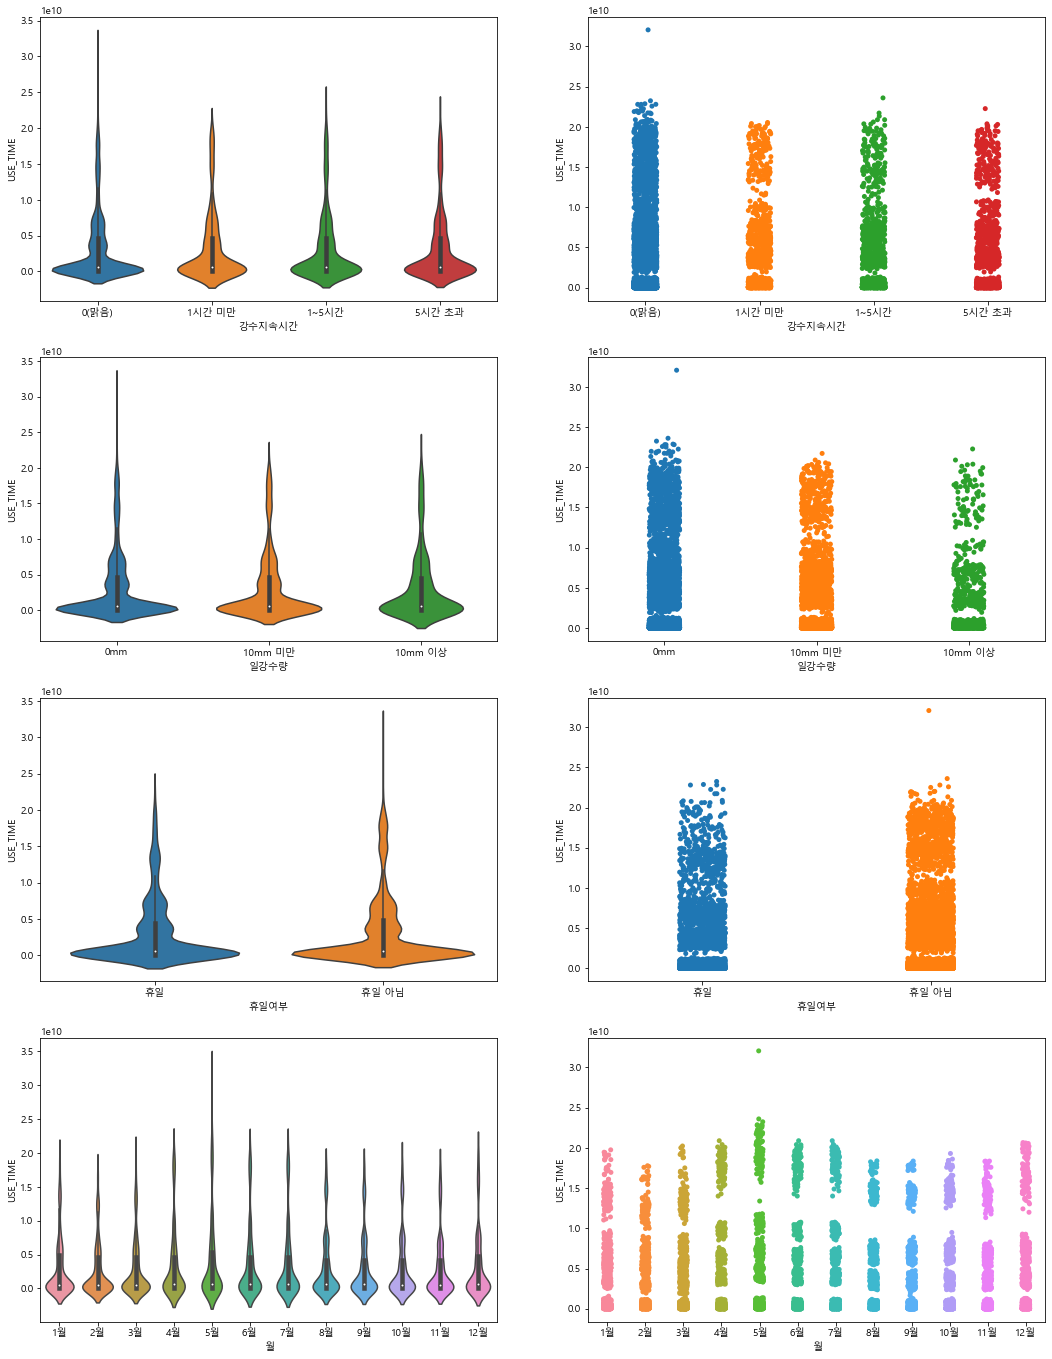

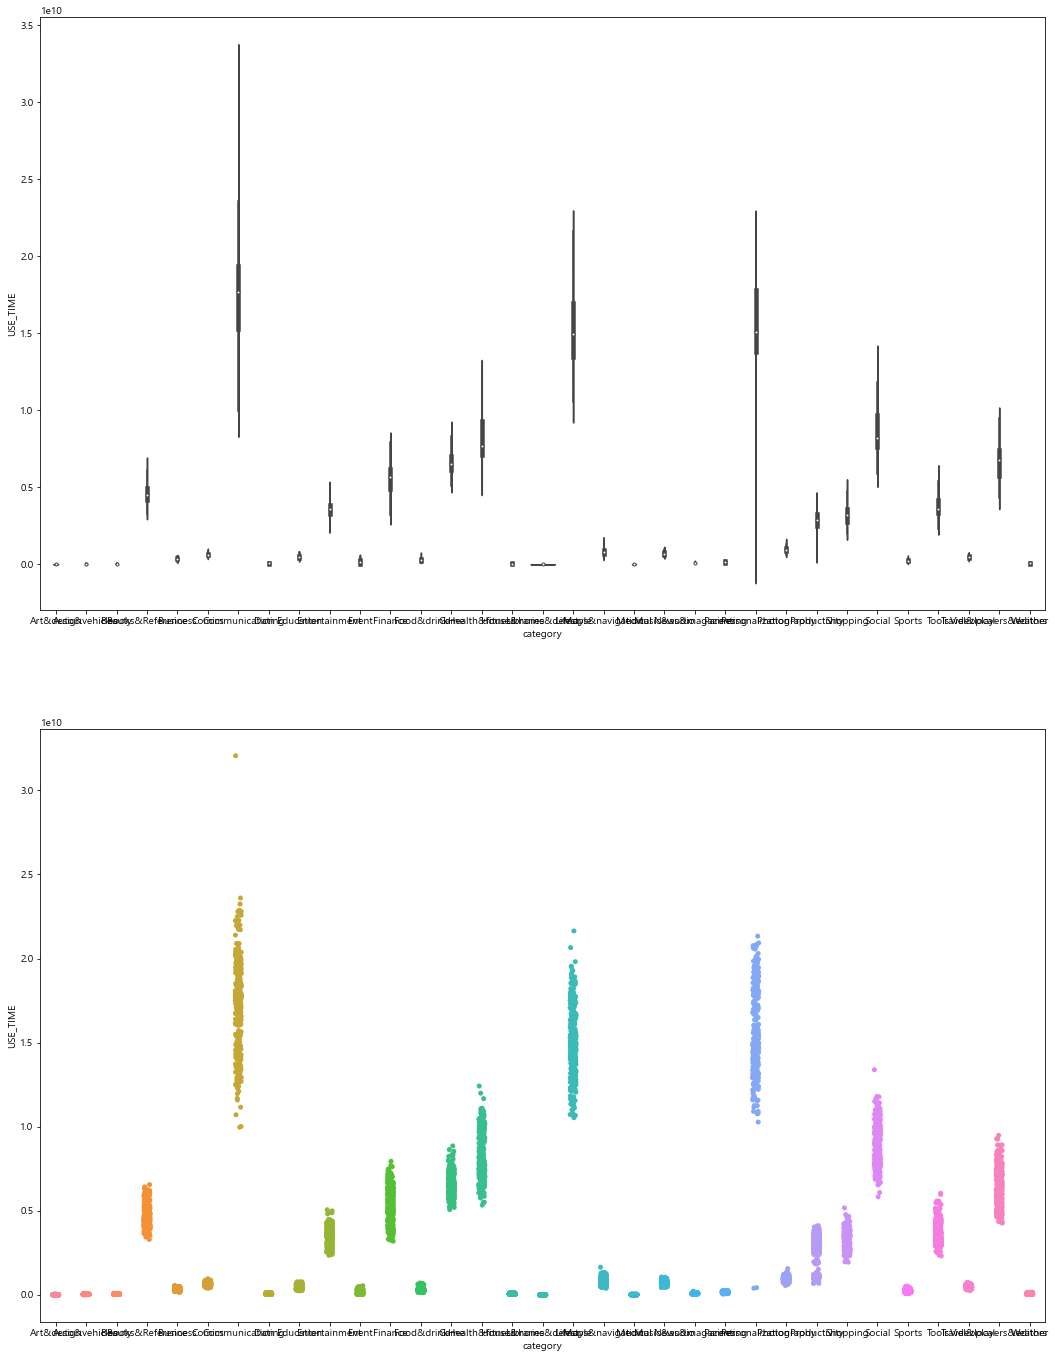

In [23]:
fig, ax = plt.subplots(4, 2, figsize = (18,24))
sns.violinplot(x='강수지속시간', y='USE_TIME', data = value, ax = ax[0,0])
sns.stripplot(x='강수지속시간', y='USE_TIME', data = value, ax = ax[0,1])

sns.violinplot(x='일강수량', y='USE_TIME', data = value, ax = ax[1,0])
sns.stripplot(x='일강수량', y='USE_TIME', data = value, ax = ax[1,1])

sns.violinplot(x='휴일여부', y='USE_TIME', data = value, ax = ax[2,0])
sns.stripplot(x='휴일여부', y='USE_TIME', data = value, ax = ax[2,1])

sns.violinplot(x='월', y='USE_TIME', data = value, ax = ax[3,0])
sns.stripplot(x='월', y='USE_TIME', data = value, ax = ax[3,1])
plt.show()

fig, axes = plt.subplots(2, 1, figsize = (18,24))

sns.violinplot(x='category', y='USE_TIME', data = value, ax = axes[0])
sns.stripplot(x='category', y='USE_TIME', data = value, ax = axes[1])
plt.show()

In [29]:
print("stop")

stop


#### GLS 미세먼지 + 미세먼지 변화량 Interactive 

In [31]:
value.to_excel('data.xlsx', index= False)

In [32]:
value

,일시,category,강수지속시간,일강수량,평균기온,평균풍속,평균상대습도,합계일사량,평균전운량,미세먼지,미세먼지_변화량,휴일여부,월,USE_TIME
0,2019-01-01,Art&design,0(맑음),0mm,-1.833547,0.150976,-0.600268,-0.968110,-0.744023,-0.258076,0.658731,휴일,1월,601914
1,2019-01-01,Auto&vehicles,0(맑음),0mm,-1.833547,0.150976,-0.600268,-0.968110,-0.744023,-0.258076,0.658731,휴일,1월,33910398
2,2019-01-01,Beauty,0(맑음),0mm,-1.833547,0.150976,-0.600268,-0.968110,-0.744023,-0.258076,0.658731,휴일,1월,22857947
3,2019-01-01,Books&Reference,0(맑음),0mm,-1.833547,0.150976,-0.600268,-0.968110,-0.744023,-0.258076,0.658731,휴일,1월,6073498792
4,2019-01-01,Business,0(맑음),0mm,-1.833547,0.150976,-0.600268,-0.968110,-0.744023,-0.258076,0.658731,휴일,1월,227420017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11776,2019-12-31,Sports,1~5시간,0mm,-1.983467,1.845031,-1.219075,-0.467907,-1.316393,-0.780189,-0.623592,휴일 아님,12월,160915841
11777,2019-12-31,Tools,1~5시간,0mm,-1.983467,1.845031,-1.219075,-0.467907,-1.316393,-0.780189,-0.623592,휴일 아님,12월,4190390750
11778,2019-12-31,Travel&local,1~5시간,0mm,-1.983467,1.845031,-1.219075,-0.467907,-1.316393,-0.780189,-0.623592,휴일 아님,12월,508906531
11779,2019-12-31,Videoplayers&editors,1~5시간,0mm,-1.983467,1.845031,-1.219075,-0.467907,-1.316393,-0.780189,-0.623592,휴일 아님,12월,6936709541


In [37]:
feature_name = ["C(category)"] + list(value.columns[2:-1])
# 잔차 추가(augementation): 범주형 독립변수가 있으면 상수항은 포함시키지 않는다.
# value = sm.add_constant(value)

# OLS 회귀 적용(이유: 시계열 가중치 얻기 위함)
model = sm.OLS.from_formula("USE_TIME ~ 0 + " + "+".join(feature_name) + " + 미세먼지_변화량 * 미세먼지", data = value).fit()

# 모델의 잔차 구함
ols_resid = model.resid

# 잔차 간의 시계열(일로 +1, -1)간의 회귀  
res_fit = sm.OLS(list(ols_resid[1:]), list(ols_resid[:-1])).fit()

# OLS 잔차 간의 상관계수의 계수(일관된 추정치 값)
rho = res_fit.params

print(res_fit.summary())

# 잔차 간의 상관계수 확인: 매우 높음
print("--------------------------------------------------------------")
print("잔차 간의 Corrleation(T 분포): " + str(res_fit.tvalues[0]))
print("잔차 간의 Corrleation(pvalue): " + str(res_fit.pvalues[0]))

from scipy.linalg import toeplitz #  퇴플리츠 행렬 modlue

# 시계열 길이 맞춘 퇴플리츠 행렬 생성 후 시걔열 간의 잔차 간의 상관정도를 행렬 만듦
order = toeplitz(np.arange(len(ols_resid)))
sigma = rho**order # 오차 공분산 구조가 실제로 자기 상관 구조를 정의
# GLS 적용 
gls_model = sm.GLS.from_formula("USE_TIME ~ " + "+".join(feature_name) + "+ 미세먼지_변화량 * 미세먼지", data = value, sigma = sigma)
gls_results = gls_model.fit()
print(gls_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              115.9
Date:                Sun, 14 Nov 2021   Prob (F-statistic):                    6.63e-27
Time:                        16:54:26   Log-Likelihood:                     -2.5875e+05
No. Observations:               11780   AIC:                                  5.175e+05
Df Residuals:                   11779   BIC:                                  5.175e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [41]:
"USE_TIME ~ 0 + " + "+".join(feature_name) + " + 미세먼지_변화량 * 미세먼지"

'USE_TIME ~ 0 + C(category)+강수지속시간+일강수량+평균기온+평균풍속+평균상대습도+합계일사량+평균전운량+미세먼지+미세먼지_변화량+휴일여부+월 + 미세먼지_변화량 * 미세먼지'

#### 정리 
coef =  pd.DataFrame(gls_results.params).reset_index().rename(columns = {0 : 'coef', 'index' : 'feature_name'})
tvalue = pd.DataFrame(gls_results.tvalues).reset_index().rename(columns = {0 : 't', 'index' : 'feature_name'}).round(3)
pvalue = pd.DataFrame(gls_results.pvalues).reset_index().rename(columns = {0 : 'pvalue', 'index' : 'feature_name'}).round(3)

inf = pd.merge(coef, tvalue, how = 'left', on = 'feature_name')
inf = pd.merge(inf, pvalue, how = 'left', on = 'feature_name')
inf.to_excel('논문 작성 도움.xlsx')

In [40]:
"+".join(feature_name)

'C(category)+강수지속시간+일강수량+평균기온+평균풍속+평균상대습도+합계일사량+평균전운량+미세먼지+미세먼지_변화량+휴일여부+월'

In [39]:
"USE_TIME ~ 0 + " + "+".join(feature_name) + " + C(category)* 미세먼지"  + "+ 미세먼지_변화량 * 미세먼지"

'USE_TIME ~ 0 + C(category)+강수지속시간+일강수량+평균기온+평균풍속+평균상대습도+합계일사량+평균전운량+미세먼지+미세먼지_변화량+휴일여부+월 + C(category)* 미세먼지+ 미세먼지_변화량 * 미세먼지'

In [31]:
feature_name = ["C(category)"] + list(value.columns[2:-1])
# 잔차 추가(augementation): 범주형 독립변수가 있으면 상수항은 포함시키지 않는다.
# value = sm.add_constant(value)

# 1적용(이유: 시계열 가중치 얻기 위함)
model_interaction = sm.OLS.from_formula("USE_TIME ~ 0 + " + "+".join(feature_name) + " + C(category)* 미세먼지"  
                                        + "+ 미세먼지_변화량 * 미세먼지", data = value).fit()

# 모델의 잔차 구함
ols_resid = model_interaction.resid

# 잔차 간의 시계열(일로 +1, -1)간의 회귀  
res_fit = sm.OLS(list(ols_resid[1:]), list(ols_resid[:-1])).fit()

# OLS 잔차 간의 상관계수의 계수(일관된 추정치 값)
rho = res_fit.params

print(res_fit.summary())

# 잔차 간의 상관계수 확인: 매우 높음
print("--------------------------------------------------------------")
print("잔차 간의 Corrleation(T 분포): " + str(res_fit.tvalues[0]))
print("잔차 간의 Corrleation(pvalue): " + str(res_fit.pvalues[0]))

from scipy.linalg import toeplitz #  퇴플리츠 행렬 modlue

# 시계열 길이 맞춘 퇴플리츠 행렬 생성 후 시걔열 간의 잔차 간의 상관정도를 행렬 만듦
order = toeplitz(np.arange(len(ols_resid)))
sigma = rho**order # 오차 공분산 구조가 실제로 자기 상관 구조를 정의
# GLS 적용 
gls_model_interaction = sm.GLS.from_formula("USE_TIME ~ " + "+".join(feature_name) + " + C(category) * 미세먼지"
                                             + "+ 미세먼지_변화량 * 미세먼지", data = value, sigma = sigma)
gls_interaction_results = gls_model_interaction .fit()
print(gls_interaction_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              116.8
Date:                Sun, 14 Nov 2021   Prob (F-statistic):                    4.21e-27
Time:                        14:02:53   Log-Likelihood:                     -2.5858e+05
No. Observations:               11780   AIC:                                  5.172e+05
Df Residuals:                   11779   BIC:                                  5.172e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### 정리 
coef =  pd.DataFrame(gls_interaction_results .params).reset_index().rename(columns = {0 : 'coef', 'index' : 'feature_name'})
tvalue = pd.DataFrame(gls_interaction_results .tvalues).reset_index().rename(columns = {0 : 't', 'index' : 'feature_name'}).round(3)
pvalue = pd.DataFrame(gls_interaction_results .pvalues).reset_index().rename(columns = {0 : 'pvalue', 'index' : 'feature_name'}).round(3)

inf = pd.merge(coef, tvalue, how = 'left', on = 'feature_name')
inf = pd.merge(inf, pvalue, how = 'left', on = 'feature_name')
inf.to_excel('논문 작성 도움_2.xlsx')

In [32]:
model_coef =  pd.DataFrame(gls_results.params).reset_index().rename(columns = {0 : 'coef', 'index' : 'feature_name'})
model_tvalue = pd.DataFrame(gls_results.tvalues).reset_index().rename(columns = {0 : 't', 'index' : 'feature_name'})
model_pvalue = pd.DataFrame(gls_results.pvalues).reset_index().rename(columns = {0 : 'pvalue', 'index' : 'feature_name'})

model_inf = pd.merge(model_coef, model_tvalue, how = 'left', on = 'feature_name')
model_inf = pd.merge(model_inf, model_pvalue, how = 'left', on = 'feature_name')
model_inf = model_inf.set_index('feature_name')
model_inf = model_inf.T

coef = model_inf.head(3)

model_interaction_coef =  pd.DataFrame((gls_interaction_results.params).reset_index().rename(columns = {0 : 'interactino_coef', 
                                                                                                         'index' : 'feature_name'}))
model_interaction_coef = model_interaction_coef.set_index('feature_name')
model_interaction_coef = model_interaction_coef.T

In [33]:
category_list = []
category_interaction_list = []
category_name = [] 

for i in list(model_interaction_coef.columns):
    if 'C(category)' in i:
        if '미세먼지' not in i:
            category_list.append(i)
        else:
            category_interaction_list.append(i)

for i in category_list:
    category_name.append(i.split('[')[1].split(']')[0][2:])
    
category_coef = coef.loc[:,category_list]
category_interaction_coef = model_interaction_coef.loc[:,category_interaction_list]

In [34]:
dust_coef = list(model_interaction_coef.loc[:,'미세먼지'])[0]

data = pd.DataFrame({'cat_coef' : list(category_coef.T['coef']),
                     'cat_coef_tvalue' : list(category_coef.T['t']),
                     'cat_coef_pvalue' : list(category_coef.T['pvalue']),
                     'cat_interaction_coef' : list(category_interaction_coef.T['interactino_coef'])})
data.index = category_name 
data['cat_interaction_coef+dust_coef'] = data['cat_interaction_coef'] + dust_coef 

In [35]:
only_order = data.sort_values(by = 'cat_coef', ascending = False)

only_order['cat_coef_pvalue_result'] = only_order['cat_coef_pvalue'].agg(lambda x: 'p_value < 0.05(유의미함)' 
                                                                 if x < 0.05 else 'p >= 0.05 (유의미하지 않음)')

In [36]:
only_order['cat_coef_tvalue'] = only_order['cat_coef_tvalue'].round(3)
only_order['cat_coef_pvalue'] = only_order['cat_coef_pvalue'].round(3)

In [37]:
only_order.to_excel('결과값(미세먼지변화량+미세먼지).xlsx')

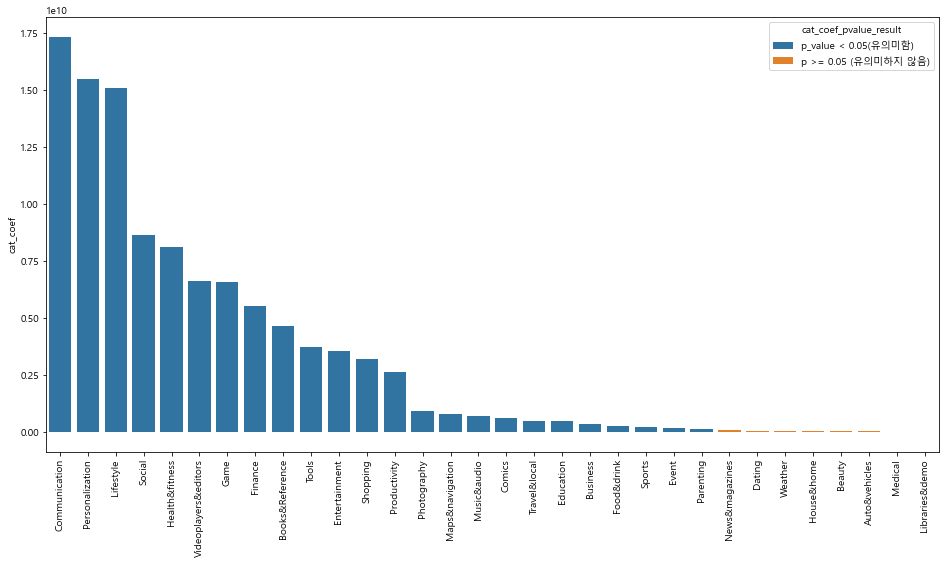

In [38]:
plt.figure(figsize = (16,8))
sns.barplot(y= 'cat_coef', x = only_order.index, data = only_order, hue = 'cat_coef_pvalue_result', dodge = False)
plt.xticks(rotation = 90)
plt.show()

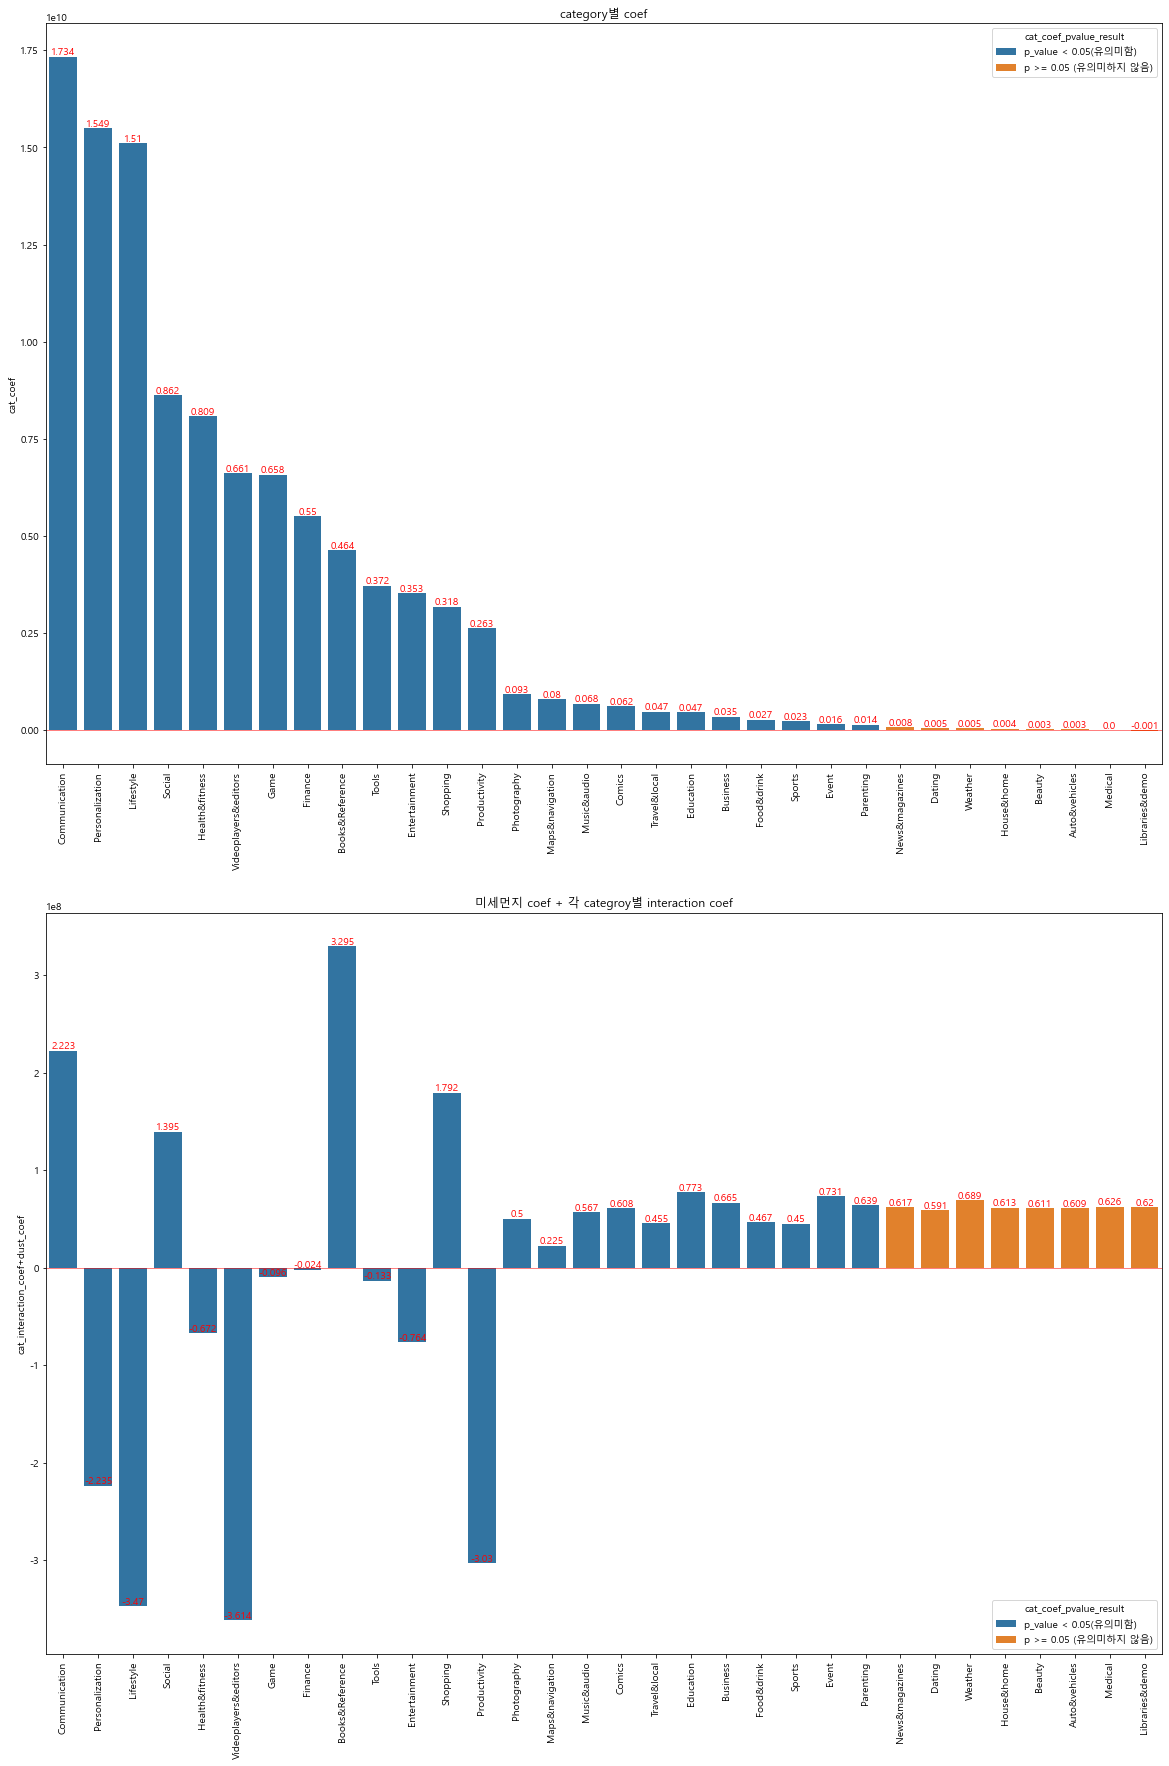

<Figure size 1152x576 with 0 Axes>

In [39]:
fig, ax = plt.subplots(2, 1, figsize = (20,30))

plt.figure(figsize = (16,8))
sns.barplot(y= 'cat_coef', x = only_order.index, data = only_order, hue = 'cat_coef_pvalue_result', 
            dodge = False, ax = ax[0])
ax[0].set_xticklabels(list(only_order.index), rotation =90)
ax[0].set_title('category별 coef')

for i, v in enumerate(only_order['cat_coef']):
    ax[0].text(i, only_order.iloc[i,0], round(v / 1e10, 3),             
             fontsize = 10, 
             color='red',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
ax[0].axhline(0, color='red', lw=0.5)

sns.barplot(y= 'cat_interaction_coef+dust_coef', x = only_order.index, data = only_order, hue = 'cat_coef_pvalue_result', 
            dodge = False, ax = ax[1])
ax[1].set_xticklabels(list(only_order.index), rotation = 90)

for i, v in enumerate(only_order['cat_interaction_coef+dust_coef']):
    ax[1].text(i, only_order.iloc[i,-2] ,round(v / 1e8, 3),             
             fontsize = 10, 
             color='red',
             horizontalalignment='center',  
             verticalalignment='bottom') 
    
ax[1].axhline(0, color='red', lw=0.5)
ax[1].set_title('미세먼지 coef + 각 categroy별 interaction coef')

plt.show()